# VICReg: Variance-Invariance-Covariance Regularization for Self-Supervised Learning

In this notebook, we'll be implementing [VICReg: Variance Invariance Covariance Regularization for Self supervised Learning](https://arxiv.org/abs/2105.04906) paper using JAX/Flax framework. VICReg is authored by Adrien Bardes along with  Jean Ponce & Yann LeCun and was published at ICLR 2022.

VICReg falls under the category of Non-contrastive methods applied to joint embedding architectures for Self-Supervised Learning (SSL). Despite it's simplicity, it performs on par with other SSL methods and supervised baselines on downstream tasks such as image classification & object detection.

**Keywords:** Self-supevised Learning, Representation Learning

## Introduction

Self Supervised Learning (SSL) is the hottest topic in AI/ML at the moment. SSL is a method for learning representations from unlabeled data. While Self-supervised learning has made a huge success in Natural Language Processing (Eg: BERT, GPT), SSL has shown significant progress only in the recent years (Eg: [DINO](https://arxiv.org/abs/2104.14294)).

There are 2 popular methods for SSL applied to Vision, Contrastive Learning and Non-Contrastive Learning methods. Joint embedding architecture (JEA) is a core part behind these 2 methods. In simple terms, JEA consists of two networks which are trained to produce similar embeddings for different views of the same image. Siamese network is a popular instance of JEA, where the two networks share the same weights.

In Contrastive learning, JEA is trained to maximize the similarity between different views of the same image (positves) and to minimize the similarity between views of the different images (negatives). The challenge with contrastive learning is it requires a large batch size to work well which is very costly.Whereas in Non-contrastive learning, JEA is just trained to maximize the similarity between positives and no negatives are used. But the main challenge with Non-contrastive learning is to prevent a collapse in which the two networks ignore the inputs and produce identical & constant vectors. Several methods (Eg: [Barlow twins](https://arxiv.org/abs/2103.03230), [W-MSE](https://arxiv.org/abs/2007.06346)) have been proposed to prevent collapse in the context of non-contrastive learning, among which VICReg is insanely simple and yet effective method.

## VICReg Method

![](https://raw.githubusercontent.com/facebookresearch/vicreg/main/.github/vicreg_archi_full.jpg)

<center> Illustration of VICReg method <center>


As you can see in the above illustration, two different views (X,X') of the batch of images (I) are generated using transformations (T), which are then passed to the joint embedding architecture to produce the embeddings (Z,Z'). Loss is calculated between the embeddings Z and Z' which needs to be minimized.

Next section describes how to compute the loss given the embeddings.

## VICReg Loss

The main component of the VICReg method is the Loss which needs to be minimized. The loss is a linear combination of 3 separate losses,


1.   **Invariance loss**: mean square distance between Z & Z'.
2.   **Variance loss**: a hinge loss to maintain the standard deviation (over a batch) of each variable of the embedding above a given threshold.
3.   **Covariance loss**: attracts the covariances (over a batch) between every pair of (centered) embedding variables towards zero.

***Use of loss***:
Invariance loss helps in increasing the similarity between the embeddings (Z,Z'). Variance loss forces the embeddings of samples within a batch to be different. Covariance loss decorrelates the variables of each embedding or in other words, increases the information content of the embedding.

Overall, the loss effectively prevents the collapse.


## Import Libraries

In [ ]:
!pip install --quiet flax
#Install flaxmodels
!pip install --quiet --upgrade git+https://github.com/matthias-wright/flaxmodels.git

     |████████████████████████████████| 185 kB 33.1 MB/s 
     |████████████████████████████████| 237 kB 68.9 MB/s 
     |████████████████████████████████| 145 kB 62.7 MB/s 
     |████████████████████████████████| 51 kB 7.7 MB/s 
     |████████████████████████████████| 85 kB 4.8 MB/s 


In [ ]:
# Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

import jax
import jax.numpy as jnp
from jax import random
import flax
from flax import linen as nn
from flax.training import train_state
import optax
import flaxmodels

import torch
import torchvision
from torchvision import datasets, transforms 

## Config dictionary

In [ ]:
#for storing hyperparameters
config = {
    "data_path": "./Dataset",
    "hidden_dim": 1024,
    "ssl_lr":0.2, # ssl_lr = (batch_size / 256) * base_lr , where base_lr = 0.2
    "lr": 1e-3,
    "lambda": 25,
    "mu": 25,
    "nu": 1,
    "weight_decay": 1e-6,
    "num_classes":10,
    "ssl_batch_size":256,
    "seed": 42}

## Preparing the Data

### Data augmentation

Torchvision library is used for performing Data augmentation inorder to produce different views of the image. Data augmentation is still performed by CPU, so it can take a significant amount of time to prepare the data. As an alternative, [PIX](https://dm-pix.readthedocs.io/en/latest/) is an image processing library in JAX and can be executed on GPU/TPU to speed up the data preparation. 

I plan to use PIX instead of torchvision in future versions of this notebook, so stay tuned! 

In [ ]:
class DataAugmentation(object):
  def __init__(self, num_views=2):
    self.img_augmentation = transforms.Compose([
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomResizedCrop(size=96),
                                        transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.5,
                                                                     contrast=0.5,
                                                                     saturation=0.5,
                                                                     hue=0.1)], p=0.8),
                                        transforms.RandomGrayscale(p=0.2),
                                        transforms.GaussianBlur(kernel_size=9),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5,), (0.5,))
                                              ])
    self.num_views = num_views

  def __call__(self, img):
    return [self.img_augmentation(img) for i in range(self.num_views)]

In [ ]:
unlabeled_data = datasets.STL10(root=config["data_path"], split="unlabeled", download=True, transform=DataAugmentation())
unlabeled_dataloader = torch.utils.data.DataLoader(unlabeled_data, batch_size = config["ssl_batch_size"], shuffle=True)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./Dataset/stl10_binary.tar.gz to ./Dataset


### Visualizing augmented images

In [ ]:
num_imgs = 7
imgs1 = torch.stack([unlabeled_data[idx][0][0] for idx in range(num_imgs)]) #Only first 7 images in the dataset are visualized
grid1 = torchvision.utils.make_grid(imgs1, nrow=7, normalize=True, pad_value=0.6)
grid1 = grid1.permute(1, 2, 0)

imgs2 = torch.stack([unlabeled_data[idx][0][1] for idx in range(num_imgs)])
grid2 = torchvision.utils.make_grid(imgs2, nrow=7, normalize=True, pad_value=0.6)
grid2 = grid2.permute(1, 2, 0)

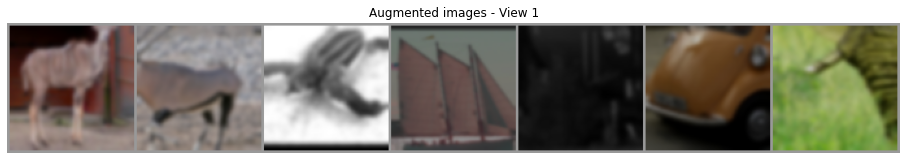

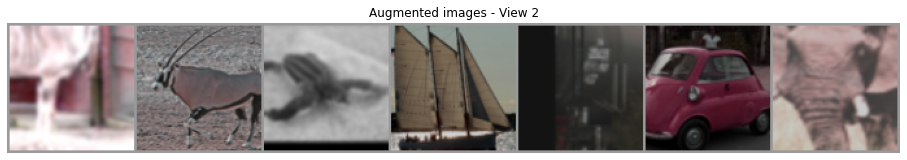

In [ ]:
plt.figure(figsize=(16,12))
plt.title("Augmented images - View 1")
plt.imshow(grid1)
plt.axis("off")
plt.show()
plt.close()

plt.figure(figsize=(16,12))
plt.title("Augmented images - View 2")
plt.imshow(grid2)
plt.axis("off")
plt.show()
plt.close()

## VICReg Implementation

### Network architecture

Joint embedding architecture consists of two networks. In this notebook, we will be working with Siamese network, so there is no need for another network. The neural network consists of two subnetworks, Encoder and Expander. In our case, encoder is the standard ResNet architecture and Exapander is a MLP where the output dimension is larger than the input dimension.

Another important aspect of VICReg is, it does not require that the weights of the two networks be shared, not that the architectures be identical, nor that the inputs be of the same nature. So VICReg can also be extended to the multi-modal setting.

In [ ]:
class VICRegNet(nn.Module):
  hidden_dim: int

  def setup(self):
    self.encoder = flaxmodels.ResNet18(output='logits',
                                       pretrained=False,
                                       normalize=False,
                                       num_classes=self.hidden_dim//2)
    layers = []
    for i in range(2):
      layers.append(nn.Dense(self.hidden_dim))
      layers.append(nn.BatchNorm(use_running_average=True))
      layers.append(nn.relu)
    layers.append(nn.Dense(self.hidden_dim))

    self.expander = nn.Sequential(layers)

  def __call__(self, x):
    x = self.encoder(x)
    x = self.expander(x)
    return x

### VICReg Self Supervised Tranining

Since BatchNormalization layer is present in ResNet architecture, we need to store batch_statistics along with params (Since JAX can't maintain state). TrainState doesn't provide any option to store the batch_stats, so we create a new class subclassing it inorder to include the batch_stats.

I didn't use any learning rate rescheduling, to keep things simple.

In [ ]:
class TrainState(train_state.TrainState):
  batch_stats: None

In [ ]:
#Function which returns the off-diagonal elements of a square matrix as a 1-d array
#useful in computing covariance loss
def off_diagonal(x):
    n, m = x.shape
    assert n == m
    out = x.flatten()[:-1].reshape(n-1,n+1)[:,1:].flatten()
    return out

In [ ]:
class VICRegTrainer:
  def __init__(self,
               config: dict):
    self.model = VICRegNet(hidden_dim=config["hidden_dim"])
    self.config = config

    self.initialize()
    self.create_functions()

  def initialize(self):
    key = random.PRNGKey(self.config["seed"])
    key, sub_key = random.split(key)
    sample_input = jnp.ones((1,96,96,3))
    variables = self.model.init(key,sample_input)
    optimizer = optax.lars(learning_rate=self.config["ssl_lr"], weight_decay=self.config["weight_decay"])
    
    self.state = TrainState.create(apply_fn=self.model.apply,
                                   params = variables["params"],
                                   batch_stats = variables["batch_stats"],
                                   tx=optimizer)
  def create_functions(self):  
    def train(dataloader, num_epochs):
      for epoch in range(num_epochs):
        for (idx, batch) in enumerate(dataloader):
          #In PyTorch, image tensors are represented in the shape of (N,C,H,W),
          #In Flax, image tensors are represented in the shape of (N,H,W,C),
          #so we need to permute the axis accordingly.
          x_a = batch[0][0].permute(0,2,3,1).numpy() #Jax don't accept torch tensors as input,
          #so we need to convert it into numpy array
          x_b = batch[0][1].permute(0,2,3,1).numpy()
          grads = jax.grad(vicreg_criterion)(self.state.params, self.state.batch_stats, x_a, x_b)
          self.state = self.state.apply_gradients(grads=grads) 
      
        print(f"Epoch {epoch+1} has completed")

    @jax.jit
    def vicreg_criterion(params, batch_stats, x_a, x_b):
      #compute representations
      z_a,_ = self.model.apply({'params': params, 'batch_stats': batch_stats}, x_a, mutable=["batch_stats"])
      z_b,_ = self.model.apply({'params': params, 'batch_stats': batch_stats}, x_b, mutable=["batch_stats"])
      
      batch_size, embed_dim = z_a.shape[0], z_a.shape[1] #useful for computing covariance loss
      
      #invariance loss
      sim_loss = optax.l2_loss(z_a, z_b).mean() * 2 #matches pytorch's implementation of mse loss

      #variance loss
      std_z_a = jnp.sqrt(z_a.var(axis=0) + 1e-04)
      std_z_b = jnp.sqrt(z_b.var(axis=0) + 1e-04)
      std_loss = (jnp.mean(jax.nn.relu(1-std_z_a)) + jnp.mean(jax.nn.relu(1-std_z_b))) * 0.5

      #covariance loss
      z_a = z_a - z_a.mean(axis=0)
      z_b = z_b - z_b.mean(axis=0)
      cov_z_a = (z_a.T @ z_a) / (batch_size - 1)
      cov_z_b = (z_b.T @ z_b) / (batch_size - 1)
      cov_loss = jnp.power(off_diagonal(cov_z_a),2).sum() / embed_dim + jnp.power(off_diagonal(cov_z_b),2).sum() / embed_dim

      loss = self.config["lambda"] * sim_loss + self.config["mu"] * std_loss + self.config["nu"] * cov_loss
      return loss

    self.train = train

In [ ]:
vicreg_ssl = VICRegTrainer(config)

In [ ]:
vicreg_ssl.train(unlabeled_dataloader, num_epochs=20)

KeyboardInterrupt: ignored

We've successfully trained the network using VICReg method. However to test whether the network has learned good representations or not, we'll retrain the network on image classification task and compare its performance on test set against the network which is trained from scratch (which is our baseline).

## Comparison to Baseline

### Trainer class for supervised learning

In [ ]:
class Trainer:
  def __init__(self,
               initialize: bool,
               config: dict):
    self.model = flaxmodels.ResNet18(output="logits", pretrained=False, normalize=False, num_classes=512)
    self.config = config
    if initialize:
      self.initialize()
    self.create_functions()

  def initialize(self):
    key = random.PRNGKey(self.config["seed"])
    key, sub_key = random.split(key)
    sample_input = jnp.ones((1,96,96,3))
    variables = self.model.init(key,sample_input)
    optimizer = optax.adamw(learning_rate=self.config["lr"], weight_decay=self.config["weight_decay"])
    
    self.state = TrainState.create(apply_fn=self.model.apply,
                                   params = variables["params"],
                                   batch_stats = variables["batch_stats"],
                                   tx=optimizer)
  def create_functions(self):  
    def train(dataloader, num_epochs):
      for epoch in range(num_epochs):
        for (idx, batch) in enumerate(dataloader):
          imgs, labels = batch
          imgs = imgs.permute(0,2,3,1).numpy()
          labels = labels.numpy()
          grads, (metrics, new_model_state) = jax.grad(classification_criterion, has_aux=True)(self.state.params, self.state.batch_stats, imgs, labels, train=True)
          self.state = self.state.apply_gradients(grads=grads, batch_stats=new_model_state['batch_stats']) 
        print(f"Epoch {epoch+1} has completed")

    def evaluate(dataloader):
      correct = 0 
      count = 0 #number of exa in the dataloader 
      for batch_idx, batch in enumerate(dataloader):
        imgs, labels = batch
        imgs = imgs.permute(0,2,3,1).numpy()
        labels = labels.numpy()
        _, (metrics, _) = classification_criterion(self.state.params, self.state.batch_stats, imgs, labels, train=False)
        #Increment the count by current batch size
        batch_size = batch[0].shape[0] #batch[0] consists of image tensor in which the first index represents batch size
        count += batch_size
        #Increment the correct by how many labels are predicted right
        correct += metrics["acc"] * batch_size
   
      print(f"Accuracy on Test set: {correct/count:4.2%} [{int(correct)}/{count}]")

    @jax.tree_util.Partial(jax.jit, static_argnums=4)
    def classification_criterion(params, batch_stats, imgs, labels, train: bool):
      output = self.model.apply({'params': params, 'batch_stats': batch_stats}, imgs, mutable=["batch_stats"]) #if train else False)
      logits, new_model_state = output #if train else (output, None)
      loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
      acc = (logits.argmax(axis=-1) == labels).mean()
      metrics = {'loss': loss.astype(float), 'acc': acc.astype(float)}
      return loss, (metrics, new_model_state)
    
    self.train = train
    self.evaluate = evaluate

### Training the VICReg model

In [ ]:
#data for supervised learning
train_data = datasets.STL10(root=config["data_path"], split="train", download=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))]))
test_data = datasets.STL10(root=config["data_path"], split="test", download=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))]))
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=False, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
vicreg = Trainer(initialize=False, config=config)

In [ ]:
#function for extracting encoder from VICRegNet model

def extract_submodule(vicreg):
  encoder = vicreg.encoder.clone()
  variables = vicreg.encoder.variables
  return encoder, variables

encoder, pretrained_variables = nn.apply(extract_submodule, vicreg_ssl.model)({'params':vicreg_ssl.state.params})

In [ ]:
#model architecture
class Classifier(nn.Module):
  num_classes: int
  backbone: nn.Module

  @nn.compact
  def __call__(self, x):
    x = self.backbone(x)
    x = nn.Dense(self.num_classes, name="head")(x)
    return x

supervised_model = Classifier(num_classes=10, backbone=encoder)
sample_input = jnp.ones((1,96,96,3))
variables = supervised_model.init(random.PRNGKey(7),sample_input)
optimizer = optax.adamw(learning_rate=config["lr"], weight_decay=config["weight_decay"])
    
#model parameters
from flax.core.frozen_dict import freeze
#update randomly initialized params with pretrained params from vicreg_ssl
variables = variables.unfreeze()
variables['params']['backbone'] = pretrained_variables['params']
variables = freeze(variables)

#Initialize attributes for vicreg
vicreg.model = supervised_model.clone()
vicreg.state = TrainState.create(apply_fn=vicreg.model.apply, params = variables["params"],batch_stats = variables["batch_stats"],tx=optimizer)

In [ ]:
vicreg.train(train_loader, num_epochs = 10)

Epoch 1 has completed
Epoch 2 has completed
Epoch 3 has completed
Epoch 4 has completed
Epoch 5 has completed
Epoch 6 has completed
Epoch 7 has completed
Epoch 8 has completed
Epoch 9 has completed
Epoch 10 has completed


In [ ]:
vicreg.evaluate(test_loader)

Accuracy on Test set: 61.26% [4901/8000]


### Training the Baseline model

In [ ]:
#baseline with initialize set to False

baseline = Trainer(initialize=False, config=config)
model = Classifier(num_classes=10, backbone=encoder)
sample_input = jnp.ones((1,96,96,3))
variables = model.init(random.PRNGKey(7),sample_input)
optimizer = optax.adamw(learning_rate=config["lr"], weight_decay=config["weight_decay"])

baseline.model = model
baseline.state = TrainState.create(apply_fn=baseline.model.apply, params = variables["params"],batch_stats = variables["batch_stats"],tx=optimizer)

In [ ]:
baseline.train(train_loader, num_epochs=10)

Epoch 1 has completed
Epoch 2 has completed
Epoch 3 has completed
Epoch 4 has completed
Epoch 5 has completed
Epoch 6 has completed
Epoch 7 has completed
Epoch 8 has completed
Epoch 9 has completed
Epoch 10 has completed


In [ ]:
baseline.evaluate(test_loader)

Accuracy on Test set: 58.76% [4701/8000]


As you can see from the above results, the model trained using VICReg performs better than baseline. It means that the model has learned meanigful representations from unlabelled data via SSL, which leads to its increased performance on labeled data (aka Transfer learning).

## Conclusion

This notebook implemented VICReg method for learning visual representations from unlabeled image data and shows that vicreg model performs better than baseline model on the test set by a reasonable margin.

This shows the self supevised learning method's ability to learn meanigful representations from unlabeled data which improves the model's performance on downstream tasks.

## References

1.   Adrien Bardes, Jean Ponce, Yann LeCun. VICReg: Variance-Invariance-Covariance Regularization for Self-Supervised Learning. ICLR 2022. ([link](https://arxiv.org/abs/2105.04906))
2.   Official codebase for VICReg ([link](https://github.com/facebookresearch/vicreg))
3.   Yann LeCun. A Path Towards Autonomous Machine Intelligence. ([link](https://openreview.net/forum?id=BZ5a1r-kVsf&referrer=[the%20profile%20of%20Yann%20LeCun](%2Fprofile%3Fid%3D~Yann_LeCun1)))
4.   SimCLR Jax/Flax Tutorial ([link](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial17/SimCLR.html))
5.   My blog on Self-supervised Learning ([link](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial17/SimCLR.html))



## Citation

```
@inproceedings{bardes2022vicreg,
  author  = {Adrien Bardes and Jean Ponce and Yann LeCun},
  title   = {VICReg: Variance-Invariance-Covariance Regularization For Self-Supervised Learning},
  booktitle = {ICLR},
  year    = {2022},
}
```

